In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# SIGINT Analysis in Python

*Tags: Inteliigence, NLP, Signals, COMINT, ELINT, Radar*

## Contents
1. Data Overview and Exploration
    - What type of signals did we receive?
    - What source and targets are most active?
2. Identify Entities
    - What entities are communicating
    - What is the relationship between entities
3. Message Prioritization
    - What is the sentiment of each message
    - Do any keywords exist in messages
    - Do any strange patterns exist
4. Concluding Analysis


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
0,S1,COMINT,2.4 GHz,FM,RSA,A1,A2,“Alpha Two sitrep?”
1,S2,ELINT,10 GHz,AM,NaN,R1,-,Radar pulse
2,S3,COMINT,5 GHz,QPSK,AES,B1,B2,"“Bravo One to Bravo Two, we have a target in s..."
3,S4,ELINT,15 GHz,FSK,NaN,R2,-,Radar sweep
4,S5,COMINT,3 GHz,PSK,RSA,C1,A1,"“Charlie One to Alpha One, we are under attack!”"


In [4]:
df.describe()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
count,35,35,35,35,14,35,21,35
unique,35,2,21,10,5,21,9,28
top,S1,ELINT,2.4 GHz,QAM,DES,A1,A1,Radar chirp
freq,1,18,6,7,5,3,5,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Signal ID    35 non-null     object
 1   Signal Type  35 non-null     object
 2   Frequency    35 non-null     object
 3   Modulation   35 non-null     object
 4   Encryption   14 non-null     object
 5   Source       35 non-null     object
 6   Destination  21 non-null     object
 7   Content      35 non-null     object
dtypes: object(8)
memory usage: 2.3+ KB


From the above summaries we can see there are a few attributes that have null entries. We know this because we have 35 rows total and some values are less than 35. 

We can make our data more readable by replacing some nulls with domain friendly language. For example, we can replace null values in the Encryption column with the value "Unecnrypted" or "Unknown".

*Note: that for some data nulls are appropriate. Destination being null is valid is the source is not transmitting a message to anyone but just creating a signal based on an action.*

In [6]:
#data prep

#replace NaN values in Encryption column with the value 'Unencrypted'
df.Encryption = df['Encryption'].fillna("Unencrypted")

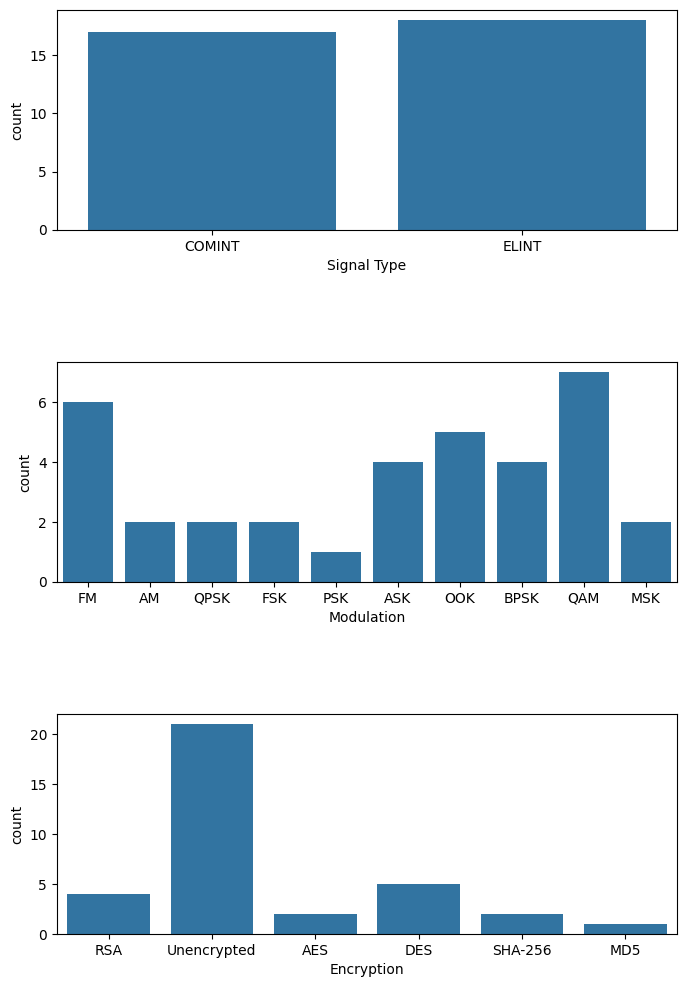

In [7]:
# visualize the signal types and encryption types present in the data.
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(8,12))

# get count by Signal Type
sns.countplot(data = df, x='Signal Type', ax=axes[0])

# get count by Modulation
sns.countplot(data = df, x='Modulation', ax=axes[1])

# get count by Encryption type
sns.countplot(data = df, x='Encryption', ax=axes[2])

plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show()


Analysis:
- About half our signals are COMINT messages and half are ELINT
- There is a wide range of modulation types but QAM makes up the majority followed by FM
- Most signals are unencrypted while DES is the most common encryption. There is also one MD5 encrypted message.

# Entity Identification

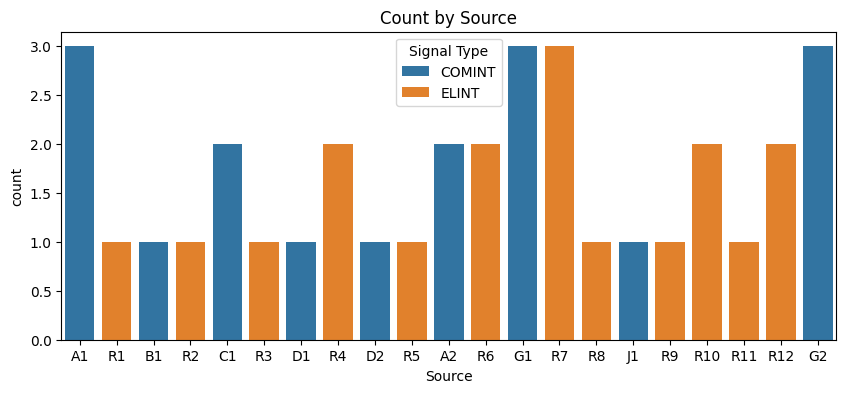

In [8]:
# What sources are most active.
fig = plt.figure(figsize=(10,4))

axes = sns.countplot(data=df, x='Source', hue='Signal Type')
axes.set_title('Count by Source')


plt.show()

From the plot above we can see that all ELINT signals are from sources that start with the letter R. All our COMINT messages are from sources labeled A, B, C, D, G, and J. 

This may be useful later. 

Additionally, there are more messages from source A1, G1, and G2. R7 also emits the most signals from ELINT messages.

G1 and G2 have the most messages indicating there may be some importance to G sources. 

In [26]:
source_count_df = df.groupby(['Signal Type', 'Source'])['Source'].count(). \
    reset_index(name='Signal Count'). \
    sort_values(by=['Signal Type', 'Signal Count'], ascending=False)

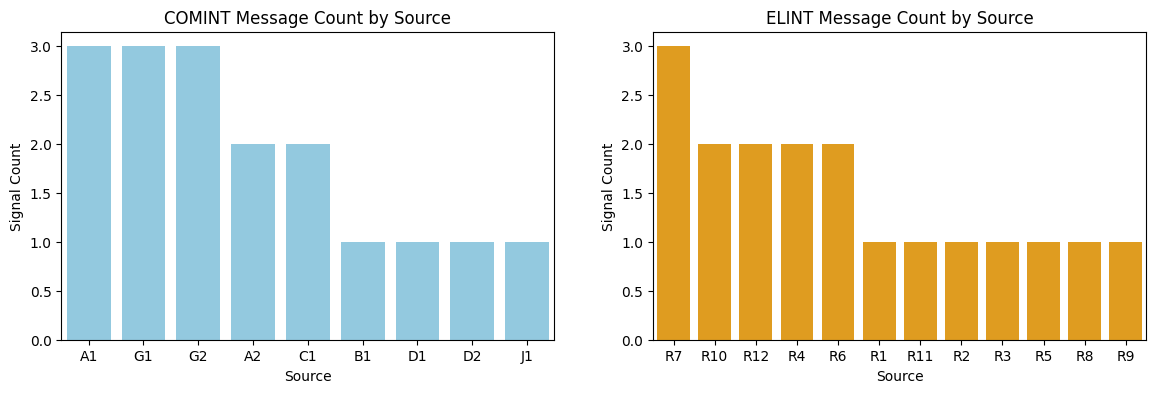

In [44]:
# visualize the sources by activity and signal type.
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,4))

# get count for COMINT
sns.barplot(data = source_count_df[source_count_df['Signal Type']=='COMINT'], x='Source', y='Signal Count',color = 'skyblue', ax=axes[0])

# get count for ELINT
sns.barplot(data = source_count_df[source_count_df['Signal Type']=='ELINT'], x='Source', y='Signal Count', color='orange', ax=axes[1])

plt.subplots_adjust(wspace=0.2, hspace=0.2)

axes[0].set_title("COMINT Message Count by Source")
axes[1].set_title("ELINT Message Count by Source")

plt.show()

Let's look at the Target/Destination column next.

In [46]:
df['Destination'].unique()

array(['A2', '-', 'B2', 'A1', 'C1', nan, 'D1', 'G2', 'J2', 'G1'],
      dtype=object)

None of the R* sources send signals to another entity. If we look at our ELINT signals message content, we can see that these rows are all radar noises. This is useful but there is little more to analyze. 

In [52]:
df[df['Signal Type'] == 'ELINT'].Content

1                          Radar pulse
3                          Radar sweep
5                          Radar burst
7                          Radar chirp
9              Radar frequency hopping
11                         Radar chirp
13                 Radar doppler shift
14                         Radar burst
15                         Radar chirp
16               Radar bistatic signal
18    Radar inverse synthetic aperture
19             Radar passive detection
20              Radar active detection
22                  Radar noise signal
27                  Radar noise signal
28                         Radar chirp
33             Radar passive detection
34                 Radar doppler shift
Name: Content, dtype: object

The rest of this analysis will focus on the COMINT signals only. 

In [53]:
#create dataframe without radar noise
comint_df = df[df['Signal Type'] == 'COMINT']
comint_df.head()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
0,S1,COMINT,2.4 GHz,FM,RSA,A1,A2,“Alpha Two sitrep?”
2,S3,COMINT,5 GHz,QPSK,AES,B1,B2,"“Bravo One to Bravo Two, we have a target in s..."
4,S5,COMINT,3 GHz,PSK,RSA,C1,A1,"“Charlie One to Alpha One, we are under attack!”"
6,S7,COMINT,4 GHz,OOK,DES,D1,C1,"“Delta One to Charlie One, moving to your posi..."
8,S9,COMINT,6 GHz,QAM,SHA-256,D2,D1,"“Delta Two to Delta One, we have secured the a..."


Let's look at the relationship between Sources and Destinations for the messages. This is a good use case for a network visual. 

In [54]:
#plot visual showing relationship between sources and destinations

In [62]:
comint_df[['Source','Destination']]

,Source,Destination
0,A1,A2
2,B1,B2
4,C1,A1
6,D1,C1
8,D2,D1
10,A2,A1
12,G1,G2
17,J1,J2
21,C1,A1
23,G2,G1


In [58]:
G = nx.from_pandas_adjacency(comint_df[['Source','Destination']])
G.name = "Graph from pandas adjacency matrix"
print(G)

NetworkXError: ('Columns must match Indices.', '[0, 2, 4, 6, 8, 10, 12, 17, 21, 23, 24, 25, 26, 29, 30, 31, 32] not in columns')